# Setup
## Importing Libraries

In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

## Reading in the Data

In [34]:
path = Path("./BookofMormon.txt")
text = path.read_text(encoding="utf-8")
print(f"Loaded {len(text)} characters from {path}")

Loaded 1530112 characters from BookofMormon.txt


In [35]:
print(text[0:100])

1 Nephi 1
Chapter 1

1 Nephi 1:1
 1 I, Nephi, having been born of goodly parents, therefore I was
ta


## Process the data

First we need to find the start of each chapter, so we can split the text into chapters.

In [36]:

# Regex matches headings like "Chapter 10"
# Breakdown:
#  - 'Chapter'  : literal text
#  - '\s+'      : one or more whitespace characters
#  - '(\d+)'    : capture group for the chapter number (one or more digits)
#  - '\b'       : word boundary so the number stops at its end
chapter_pattern = re.compile(r'Chapter\s+(\d+)\b')
# Collect (full_match, chapter_number_as_int, start_pos, end_pos) for each match
chapter_matches = [(m.group(0), int(m.group(1)), m.start(), m.end()) for m in chapter_pattern.finditer(text)]

print(f"Found {len(chapter_matches)} matches")
starts = []
ends = []
names = []
for name, num, start_pos, end_pos in chapter_matches:
    # find newline immediately before the chapter match
    prev_nl = text.rfind("\n", 0, start_pos)
    if prev_nl == -1:
        # no newline: the previous line starts at beginning of text
        prev_line_start = 0
        prev_line_end = start_pos
    else:
        # find start of the previous line (the newline before prev_nl)
        prev_prev_nl = text.rfind("\n", 0, prev_nl)
        prev_line_start = prev_prev_nl + 1 if prev_prev_nl != -1 else 0
        prev_line_end = prev_nl

    prev_line = text[prev_line_start:prev_line_end].strip()
    print(prev_line_start, prev_line_end, f'{prev_line}, {name}', num, "(chapter start, end):", start_pos, end_pos)
    starts.append(prev_line_start)
    ends.append(end_pos)
    names.append(prev_line)

Found 239 matches
0 9 1 Nephi 1, Chapter 1 1 (chapter start, end): 10 19
5145 5154 1 Nephi 2, Chapter 2 2 (chapter start, end): 5155 5164
10228 10237 1 Nephi 3, Chapter 3 3 (chapter start, end): 10238 10247
16301 16310 1 Nephi 4, Chapter 4 4 (chapter start, end): 16311 16320
23386 23395 1 Nephi 5, Chapter 5 5 (chapter start, end): 23396 23405
27854 27863 1 Nephi 6, Chapter 6 6 (chapter start, end): 27864 27873
28971 28980 1 Nephi 7, Chapter 7 7 (chapter start, end): 28981 28990
34441 34450 1 Nephi 8, Chapter 8 8 (chapter start, end): 34451 34460
41265 41274 1 Nephi 9, Chapter 9 9 (chapter start, end): 41275 41284
42750 42760 1 Nephi 10, Chapter 10 10 (chapter start, end): 42761 42771
48053 48063 1 Nephi 11, Chapter 11 11 (chapter start, end): 48064 48074
55416 55426 1 Nephi 12, Chapter 12 12 (chapter start, end): 55427 55437
60366 60376 1 Nephi 13, Chapter 13 13 (chapter start, end): 60377 60387
71174 71184 1 Nephi 14, Chapter 14 14 (chapter start, end): 71185 71195
78431 78441 1 Nephi

Then we can get the text of each chapter and store it in a list.

In [37]:
# get the text of each chapter.
chapter_texts = []
for i in range(len(starts)):
    #start = starts[i]
    end = ends[i]
    if i == len(ends)-1: next_start = -1
    else: next_start = starts[i+1]
    chapter_text = text[end:next_start].strip()
    chapter_texts.append(chapter_text)
print(chapter_texts[0])

1 Nephi 1:1
 1 I, Nephi, having been born of goodly parents, therefore I was
taught somewhat in all the learning of my father; and having seen
many afflictions in the course of my days, nevertheless, having
been highly favored of the Lord in all my days; yea, having had a
great knowledge of the goodness and the mysteries of God,
therefore I make a record of my proceedings in my days.

1 Nephi 1:2
 2 Yea, I make a record in the language of my father, which
consists of the learning of the Jews and the language of the
Egyptians.

1 Nephi 1:3
 3 And I know that the record which I make is true; and I make it
with mine own hand; and I make it according to my knowledge.

1 Nephi 1:4
 4 For it came to pass in the commencement of the first year of
the reign of Zedekiah, king of Judah, (my father, Lehi, having
dwelt at Jerusalem in all his days); and in that same year there
came many prophets, prophesying unto the people that they must
repent, or the great city Jerusalem must be destroyed.

1 Ne

Now we need to clean the text by removing the chapter/verse headings (1 Nephi 1:5, etc.), the verse numbers, and the newlines.

In [38]:
# Clean the text a bit
for i in range(len(chapter_texts)):
    chapter_text = chapter_texts[i]
    chapter_title = names[i]
    
    # first remove any text containing the chapter title
    pattern = re.compile(rf"{re.escape(chapter_title)}:(\d+)\b\n")
    # Remove all matches
    chapter_text = re.sub(pattern, "", chapter_text)
    
    # then remove the verse numbers
    pattern = re.compile(r" \d{1,2} ")
    chapter_text = re.sub(pattern, "", chapter_text)
    
    pattern = re.compile(r"\n")
    chapter_text = re.sub(pattern, " ", chapter_text)

    # Store back the cleaned text
    chapter_texts[i] = chapter_text

print(chapter_texts[0])

I, Nephi, having been born of goodly parents, therefore I was taught somewhat in all the learning of my father; and having seen many afflictions in the course of my days, nevertheless, having been highly favored of the Lord in all my days; yea, having had a great knowledge of the goodness and the mysteries of God, therefore I make a record of my proceedings in my days.  Yea, I make a record in the language of my father, which consists of the learning of the Jews and the language of the Egyptians.  And I know that the record which I make is true; and I make it with mine own hand; and I make it according to my knowledge.  For it came to pass in the commencement of the first year of the reign of Zedekiah, king of Judah, (my father, Lehi, having dwelt at Jerusalem in all his days); and in that same year there came many prophets, prophesying unto the people that they must repent, or the great city Jerusalem must be destroyed.  Wherefore it came to pass that my father, Lehi, as he went forth

Save the cleaned text to a csv file.

In [39]:
data = pd.DataFrame({
    'chapter':names,
    'text':chapter_texts
})
data.to_csv('./processed_text.csv',index=None)
data.head()

,chapter,text
0,1 Nephi 1,"I, Nephi, having been born of goodly parents, ..."
1,1 Nephi 2,"For behold, it came to pass that the Lord spak..."
2,1 Nephi 3,"And it came to pass that I, Nephi, returned fr..."
3,1 Nephi 4,And it came to pass that I spake unto my breth...
4,1 Nephi 5,And it came to pass that after we had come dow...


# Feature Extraction

## TF-IDF Vectorization
The first type of features we will extract are TF-IDF features. These features represent the importance of each word in a document relative to the entire set of text.  They will be useful for NMF topic modeling and also for classification.

In [40]:
## once with 100 features to make LDA/QDA feasible
# 1. Create the vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',   # remove English stopwords
    max_features=100,      # limit vocabulary size
    ngram_range=(1, 1)      # (1,2) to include bigrams
)

# 2. Fit and transform the text column
tfidf_matrix = vectorizer.fit_transform(data['text'])

# 3. Convert to a DataFrame for readability
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=data['chapter'],
    columns=vectorizer.get_feature_names_out()
)

# 4. Inspect results
print(tfidf_df.shape)
tfidf_df.to_csv('./tfidf_features_100.csv')
tfidf_df.head()

(239, 100)


,according,alma,ammon,away,began,behold,believe,brethren,bring,brother,...,went,wherefore,wilderness,word,words,world,written,ye,yea,year
chapter,,,,,,,,,,,,,,,,,,,,,
1 Nephi 1,0.026433,0.0,0.0,0.085623,0.031985,0.062122,0.000000,0.000000,0.000000,0.000000,...,0.111014,0.079290,0.000000,0.000000,0.000000,0.037211,0.113533,0.026316,0.155031,0.08543
1 Nephi 2,0.024942,0.0,0.0,0.053862,0.000000,0.117235,0.073937,0.055900,0.000000,0.000000,...,0.000000,0.149635,0.269914,0.029741,0.093416,0.000000,0.000000,0.049663,0.062694,0.00000
1 Nephi 3,0.000000,0.0,0.0,0.000000,0.084697,0.255886,0.000000,0.130726,0.032845,0.039514,...,0.130651,0.209959,0.180347,0.000000,0.109230,0.032845,0.000000,0.069685,0.019549,0.00000
1 Nephi 4,0.046328,0.0,0.0,0.075034,0.028030,0.090732,0.000000,0.129788,0.032609,0.000000,...,0.162142,0.104226,0.214863,0.000000,0.130136,0.000000,0.000000,0.069185,0.116450,0.00000
1 Nephi 5,0.000000,0.0,0.0,0.000000,0.041453,0.107347,0.000000,0.038389,0.048226,0.000000,...,0.000000,0.205520,0.370721,0.000000,0.000000,0.048226,0.000000,0.000000,0.114812,0.00000


In [41]:
## Once with 5000 features for clustering
vectorizer = TfidfVectorizer(
    stop_words='english',   # remove English stopwords
    max_features=5000,      # limit vocabulary size
    ngram_range=(1, 1)      # (1,2) to include bigrams
)

# 2. Fit and transform the text column
tfidf_matrix = vectorizer.fit_transform(data['text'])

# 3. Convert to a DataFrame for readability
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=data['chapter'],
    columns=vectorizer.get_feature_names_out()
)

# 4. Inspect results
print(tfidf_df.shape)
tfidf_df.to_csv('./tfidf_features_5000.csv')
tfidf_df.head()

(239, 5000)


,aaron,abandon,abandoned,abasing,abel,abhor,abhorrence,abhorrest,abhorreth,abide,...,zenock,zenos,zerahemnah,zeram,zerin,ziff,zion,zoram,zoramite,zoramites
chapter,,,,,,,,,,,,,,,,,,,,,
1 Nephi 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1 Nephi 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1 Nephi 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1 Nephi 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100003,0.0,0.0
1 Nephi 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


We can also look at a dendrogram of the hierarchical clustering of the TF-IDF features.  Pretty interesting!

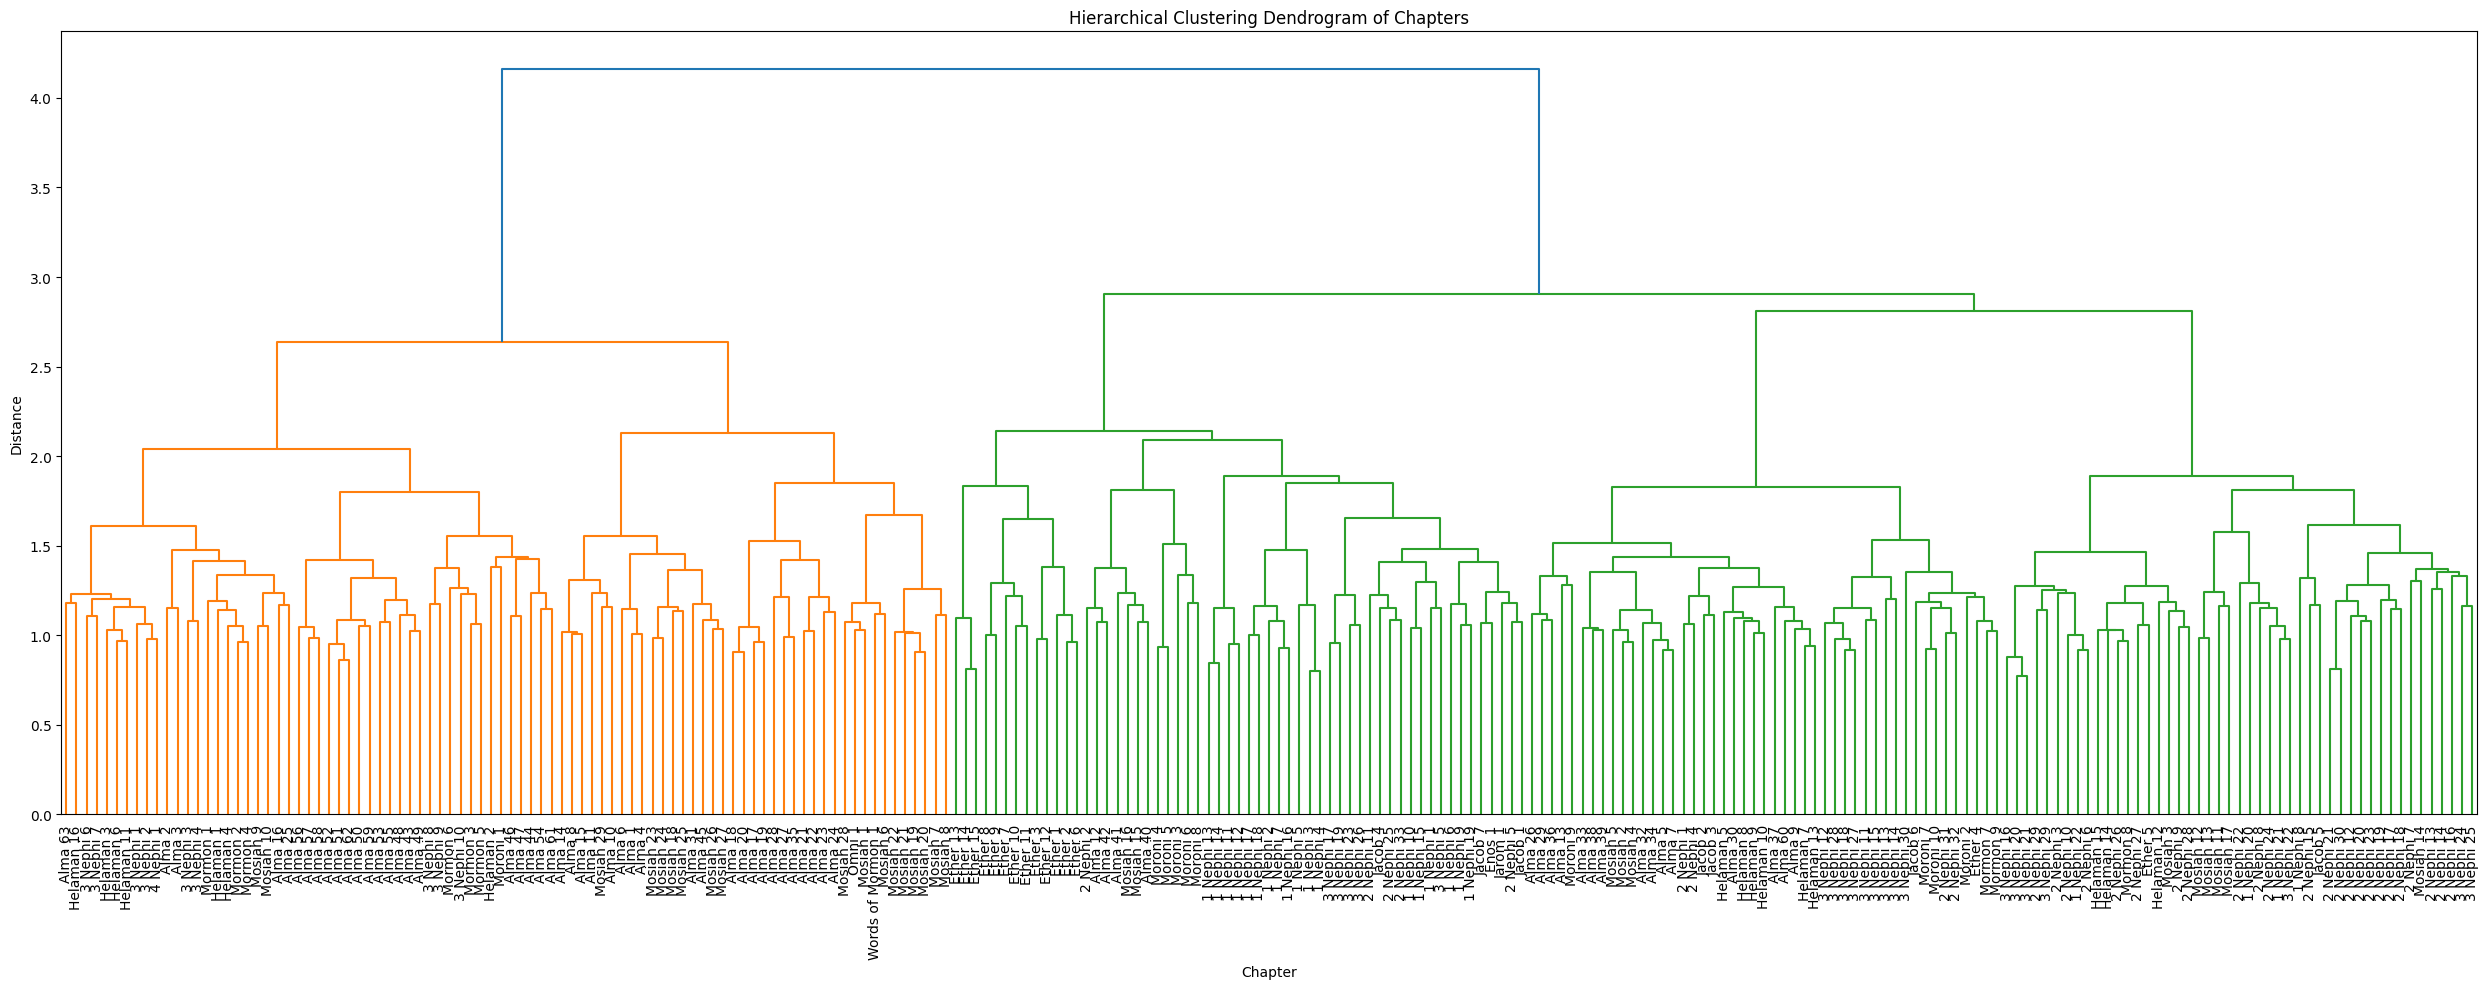

In [42]:
# 'ward' minimizes variance within clusters (Euclidean distance)
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')
plt.figure(figsize=(25, 10))
dendrogram(
    linkage_matrix,
    labels=data['chapter'].values,  # chapter names on x-axis
    leaf_rotation=90,               # rotate chapter names
    leaf_font_size=10
)
plt.title('Hierarchical Clustering Dendrogram of Chapters')
plt.xlabel('Chapter')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Word Count Vectorization
The second type of features we will extract are word count features. These features represent the raw counts of each word in a document. They will be useful for LDA topic modeling.

In [43]:
vectorizer = CountVectorizer(
    stop_words='english',  # remove common words
    max_features=5000,     # optional: limit vocabulary
    ngram_range=(1,1)      # (1,2) to include bigrams
)

X_counts = vectorizer.fit_transform(data['text'])

X_df = pd.DataFrame(
    X_counts.toarray(),
    index=data['chapter'],  # optional: use chapter names as row labels
    columns=vectorizer.get_feature_names_out()
)
X_df.to_csv('./wordcount_features.csv')
X_df.head()

,aaron,abandon,abandoned,abasing,abel,abhor,abhorrence,abhorrest,abhorreth,abide,...,zenock,zenos,zerahemnah,zeram,zerin,ziff,zion,zoram,zoramite,zoramites
chapter,,,,,,,,,,,,,,,,,,,,,
1 Nephi 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Nephi 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Nephi 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Nephi 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
1 Nephi 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
